In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import quantecon as qe
import matplotlib.pyplot as plt
import pickle

In [5]:
# Load df from the pickle file
with open('df_2010_controls2_final.pkl', 'rb') as f:
    df_2010_controls2_final = pickle.load(f)

# Create a copy
df = df_2010_controls2_final.copy()
df.head()

,county,schedule1_count,schedule2_count,total_pop_1860,log_slave,ag_output,ag_gdp_1860,gini_x,cash_value_farms,state,...,log_murder_rate,log_mtv_theft_rate,log_crime_rate,ALAND_SQMI,AWATER_SQMI,total_sqmi,pop_density_2010,total_males_15_29_1860,pop_density_1860,total_males_15_29_2010
0,10.0,360232.0,3475.0,363707.0,8.153350,32662909.0,89.805557,0.54031,129368094.0,Alabama,...,2.318692,2.961387,8.510573,594.455,9.914,604.369,90.294175,50227.0,601.796254,5295
1,30.0,292363.0,1537.0,293900.0,7.337588,27996221.0,95.257645,0.58392,152052217.0,Alabama,...,0.437385,2.859887,8.448097,1589.863,437.410,2027.273,89.906490,42867.0,144.973075,15906
2,50.0,395136.0,1872.0,397008.0,7.534763,31948684.0,80.473656,0.52155,142857209.0,Alabama,...,0.000000,0.000000,7.853968,885.008,19.507,904.515,30.355494,55791.0,438.918094,3179
3,70.0,136102.0,2639.0,138741.0,7.878155,24998235.0,180.179153,0.43734,99711086.0,Alabama,...,1.679701,3.581061,8.132966,622.470,3.696,626.166,36.595727,21539.0,221.572235,2604
4,90.0,375103.0,1078.0,376181.0,6.982863,21747586.0,57.811497,0.59723,88331569.0,Alabama,...,1.501644,2.705129,8.147122,644.891,5.738,650.629,88.102436,56997.0,578.180499,5451


***Lorenz Curve***

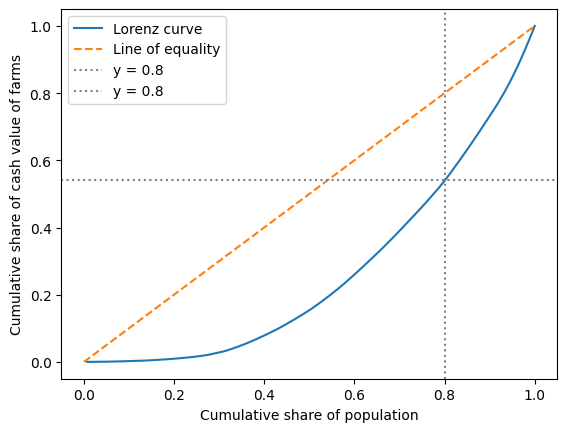

In [20]:
df = df.sort_values(by='cash_value_farms')

# Step 2: Calculate the cumulative share of the cash value of farms
df['cumulative_cash_value'] = df['cash_value_farms'].cumsum() / df['cash_value_farms'].sum()

# Step 3: Calculate the cumulative share of the population (rank as percentage)
df['cumulative_pop'] = np.arange(1, len(df) + 1) / len(df)

# Step 4: Plot the Lorenz curve
fig, ax = plt.subplots()
ax.plot(df['cumulative_pop'], df['cumulative_cash_value'], label='Lorenz curve')
ax.plot([0, 1], [0, 1], label='Line of equality', linestyle='--')
ax.axvline(x=0.8, color='gray', linestyle=':', label='y = 0.8')  
ax.axhline(y=0.54, color='gray', linestyle=':', label='y = 0.8')  
ax.set_xlabel('Cumulative share of population')
ax.set_ylabel('Cumulative share of cash value of farms')
ax.legend()
plt.show()

In [21]:
# After data preprocessing thoughts have changed on this analysis a bit

In [22]:
# Notice ~20% of the population controls ~54% of cash value of farms

# This result does not align with the "Pareto Principle" or the "80/20 rule" which suggests 
# roughly 80% of effects come from 20% of causes

# This principle was named after Italian economist Vilfredo Pareto, who observed 
# in the late 19th century that about 80% of Italy's land was owned by 20% of the population. 
# Over time, this observation has been found to apply to a variety of fields, from business and 
# economics to social science, and it has become a popular framework for understanding imbalanced 
# distributions

# Hypothesize this ~80/20 is accurate. For reference, as of 2024, top 20% of earners in the United States 
# controlled approximately 71% of the nation's total wealth. This concentration has increased over the 
# past few decades; in 1990, the top 20% held about 61% of the wealth

# This is not a question I need to answer in this paper but a question that could be answered in a following
# paper. Is this 80/20 estimate accurate

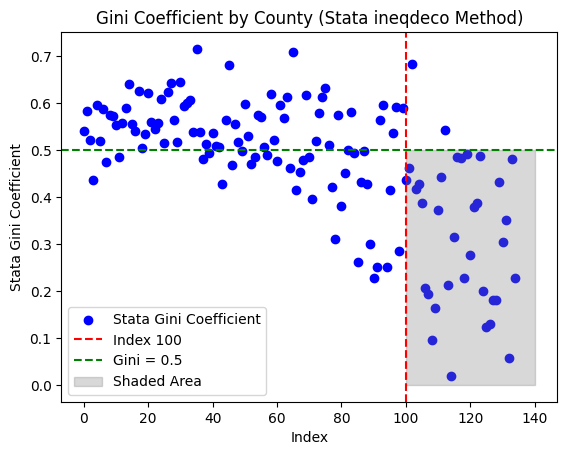

In [23]:
#Inspect econ gini calculation
plt.scatter(df.index, df['gini_stata'], color='b', label='Stata Gini Coefficient')

# Adding a vertical line at index = 100
plt.axvline(x=100, color='r', linestyle='--', label='Index 100')

# Adding a horizontal line at y = 0.5
plt.axhline(y=0.5, color='g', linestyle='--', label='Gini = 0.5')

# Get the current x-axis limits
x_limits = plt.gca().get_xlim()

# Shade the area where index > 100 and Gini < 0.5, using the original x-axis limits
plt.fill_between(np.arange(100, x_limits[1]), 0, 0.5, color='gray', alpha=0.3, label='Shaded Area')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Stata Gini Coefficient')
plt.title('Gini Coefficient by County (Stata ineqdeco Method)')

# Display the legend
plt.legend()

# Display the scatter plot
plt.show()

#Spread of gini coefficient seems a bit better, interestingly, counties numbered <100 seem to have a lower gini coefficent

#Stata ineqdeco measure of gini coefficient seems to better capture 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


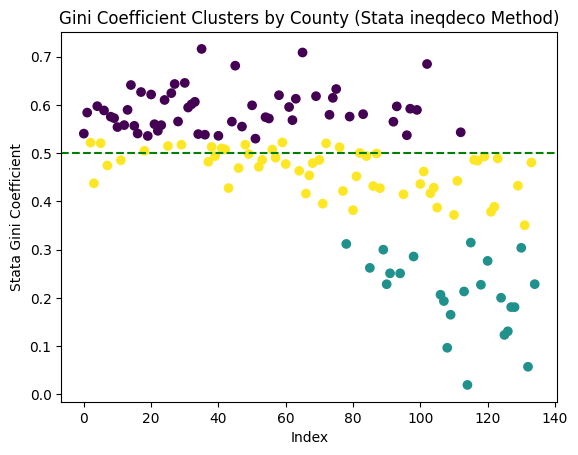

In [24]:
#K-means clustering of Gini to extract info on counties

# Remove rows with NaN values in the 'gini_stata' column (or any other columns as needed)
df = df.dropna(subset=['gini_stata'])

# Extract the Stata Gini coefficient values
gini_values = df['gini_stata'].values.reshape(-1, 1)  # Reshape to a 2D array for clustering

# Define the number of clusters (you can try different values)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the K-means model
df['cluster'] = kmeans.fit_predict(gini_values)

# Plot the results with clusters
plt.scatter(df.index, df['gini_stata'], c=df['cluster'], cmap='viridis', label='Gini Coefficient Clusters')

# Adding a horizontal line at y = 0.5 for context
plt.axhline(y=0.5, color='g', linestyle='--', label='Gini = 0.5')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Stata Gini Coefficient')
plt.title('Gini Coefficient Clusters by County (Stata ineqdeco Method)')

# Show the plot
plt.show()


In [25]:
brown_cluster_counties = df[df['cluster'] == 0]
blue_cluster_counties = df[df['cluster'] == 1]
yellow_cluster_counties = df[df['cluster'] == 2]
yellow_cluster_counties.head()

,county,schedule1_count,schedule2_count,total_pop_1860,log_slave,ag_output,ag_gdp,gini_x,cash_value_farms,state,...,ALAND_SQMI,AWATER_SQMI,total_sqmi,pop_density_2010,total_males_15_29_1860,pop_density_1860,total_males_15_29_2010,cumulative_cash_value,cumulative_pop,cluster
123,2710.0,1876.0,44.0,1920.0,3.784190,184218.0,95.946877,0.48880,299145.0,Georgia,...,437.307,6.701,444.008,37.161493,271.0,4.324246,1946,0.000047,0.007407,2
122,2650.0,1733.0,195.0,1928.0,5.273000,312827.0,162.254669,0.38865,744580.0,Georgia,...,194.607,0.740,195.347,8.789487,224.0,9.869617,158,0.000395,0.037037,2
121,2550.0,4878.0,281.0,5159.0,5.638355,494084.0,95.771271,0.37829,1126732.0,Georgia,...,195.970,3.620,199.590,321.023097,741.0,25.847988,6283,0.000898,0.059259,2
129,2970.0,6471.0,249.0,6720.0,5.517453,656068.0,97.629166,0.43229,1439900.0,Georgia,...,326.821,3.179,330.000,253.842424,925.0,20.363636,7557,0.001122,0.066667,2
116,2370.0,3035.0,367.0,3402.0,5.905362,929016.0,273.079376,0.48591,1686858.0,Georgia,...,344.682,16.005,360.687,58.826628,419.0,9.432001,1813,0.001385,0.074074,2


In [26]:
# Notice total_pop and total_age15_29 have perfect correlation
# Either one of them should be included in the model, not both

In [27]:
# Notice 80% of the data is coming from counties in Georgia and Alabama
state_counts = df['state'].value_counts()

# Display the counts
print(state_counts)
df.shape

state
Georgia       58
Alabama       51
Arkansas      15
Illinois       6
California     3
Kentucky       2
Name: count, dtype: int64


(135, 134)

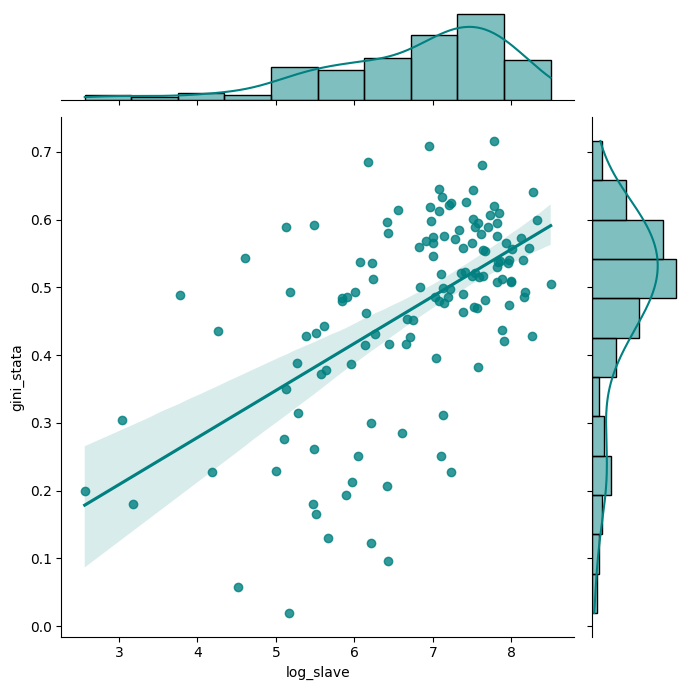

In [28]:
# Plots of gini_stata and log_slave appear to be similar, corelation is 0.56

# Lets further explore the relationship between inequality and slavery
sns.jointplot(x="log_slave", y="gini_stata", data=df, kind='reg', color='teal', height=7);

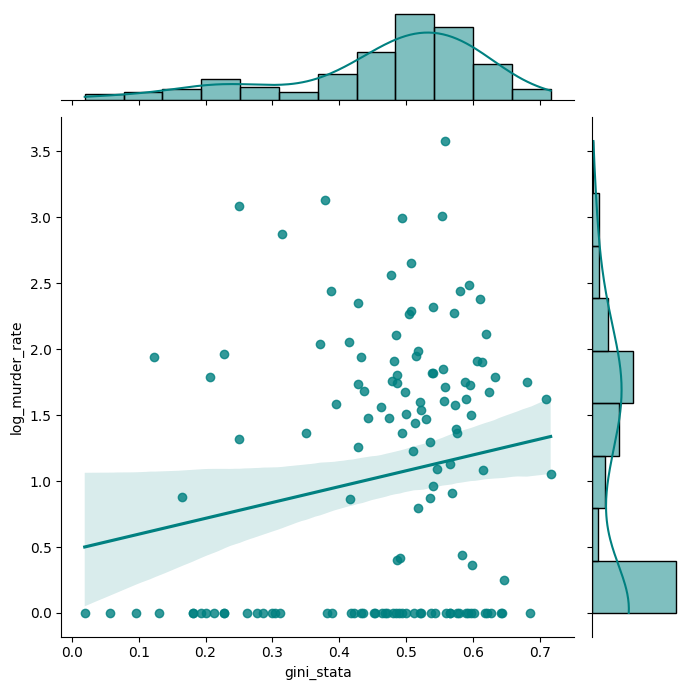

In [29]:
# Lets further explore the relationship between inequality and slavery
sns.jointplot(x="gini_stata", y="log_murder_rate", data=df, kind='reg', color='teal', height=7);

In [30]:
filtered_df = df_2010_controls2_final[(df_2010_controls2_final['MURDER'] == 0) & (df_2010_controls2_final['total_pop_2010'] > 10000)]
filtered_df.head() #41 counties
#filtered_df.shape

,county,schedule1_count,schedule2_count,total_pop_1860,log_slave,ag_output,ag_gdp,gini_x,cash_value_farms,state,...,log_murder_rate,log_mtv_theft_rate,log_crime_rate,ALAND_SQMI,AWATER_SQMI,total_sqmi,pop_density_2010,total_males_15_29_1860,pop_density_1860,total_males_15_29_2010
2,50.0,395136.0,1872.0,397008.0,7.534763,31948684.0,80.473656,0.52155,142857209.0,Alabama,...,0.0,0.000000,7.853968,885.008,19.507,904.515,30.355494,55791.0,438.918094,3179
5,110.0,251363.0,1565.0,252928.0,7.355641,34858781.0,137.820969,0.52046,154934467.0,Arkansas,...,0.0,3.794321,7.262696,649.167,3.670,652.837,17.627677,36277.0,387.429021,1073
14,290.0,109974.0,3921.0,113895.0,8.274102,24966660.0,219.207687,0.64109,122476483.0,Arkansas,...,0.0,2.985842,8.863091,551.917,14.578,566.495,37.551964,15789.0,201.052083,1915
17,350.0,69190.0,1664.0,70854.0,7.416980,10961235.0,154.701706,0.62650,51721453.0,Alabama,...,0.0,3.987465,8.375694,850.279,2.481,852.760,15.511985,10450.0,83.087856,1183
20,410.0,68276.0,1351.0,69627.0,7.208601,15585236.0,223.838974,0.62142,77789763.0,Arkansas,...,0.0,2.795765,8.483944,741.227,71.499,812.726,16.005394,10867.0,85.670940,1127


In [35]:
# Variables most interested in; sum_crime, gini_stata, log_slave. Create a dataframe with these variables
df_var_of_interest = df[['log_murder_rate', 'log_mtv_theft_rate', 'log_crime_rate', 'gini_stata', 'log_slave', 'pop_density_1860', 'pop_density_2010', 'total_males_15_29_1860', 'total_males_15_29_2010', 'ag_gdp_1860']]
df_var_of_interest.head()

,log_murder_rate,log_mtv_theft_rate,log_crime_rate,gini_stata,log_slave,pop_density_1860,pop_density_2010,total_males_15_29_1860,total_males_15_29_2010,ag_gdp_1860
0,2.318692,2.961387,8.510573,0.54031,8.153350,601.796254,90.294175,50227.0,5295,89.805557
1,0.437385,2.859887,8.448097,0.58392,7.337588,144.973075,89.906490,42867.0,15906,95.257645
2,0.000000,0.000000,7.853968,0.52155,7.534763,438.918094,30.355494,55791.0,3179,80.473656
3,1.679701,3.581061,8.132966,0.43734,7.878155,221.572235,36.595727,21539.0,2604,180.179153
4,1.501644,2.705129,8.147122,0.59723,6.982863,578.180499,88.102436,56997.0,5451,57.811497


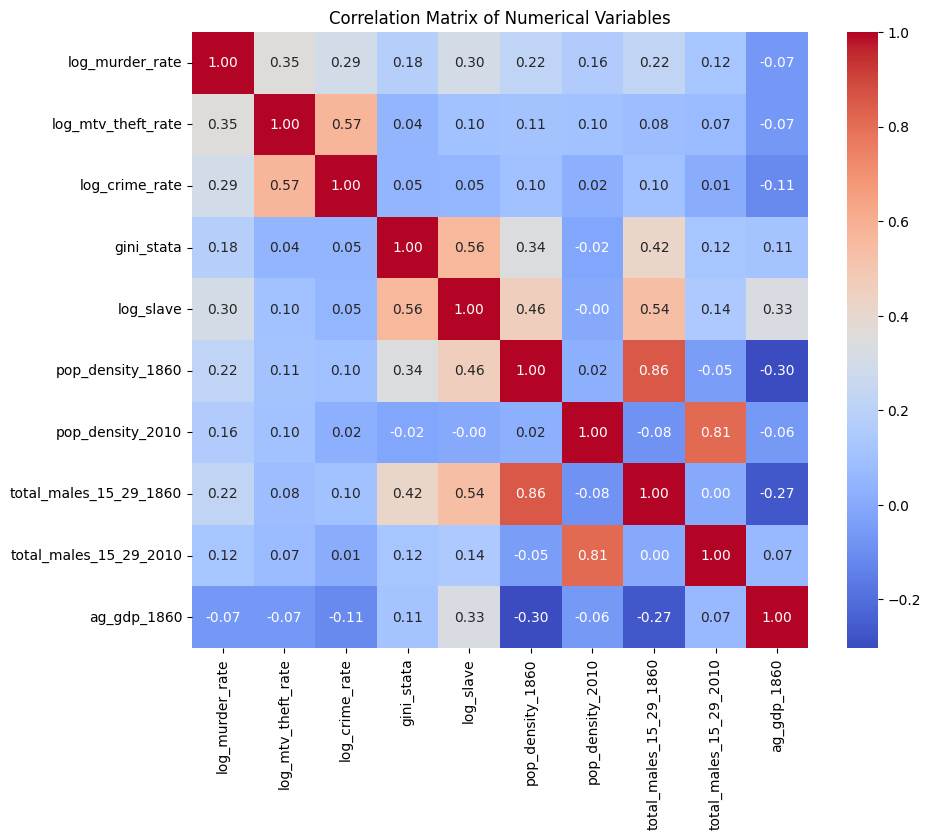

In [36]:
correlation_matrix = df_var_of_interest.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

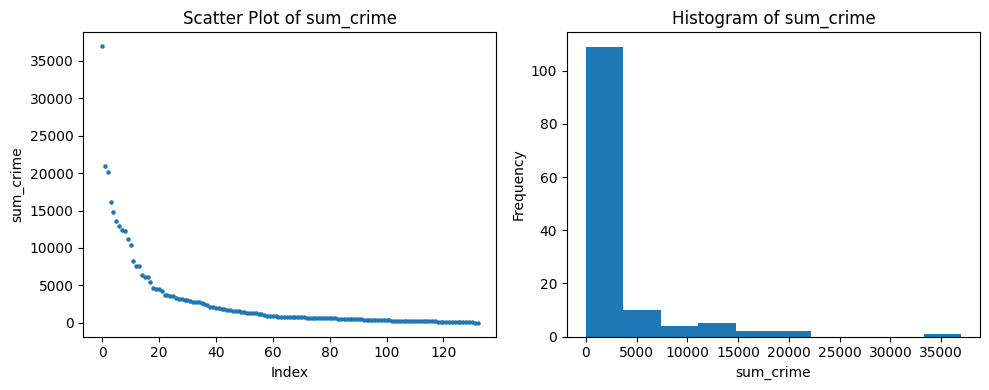

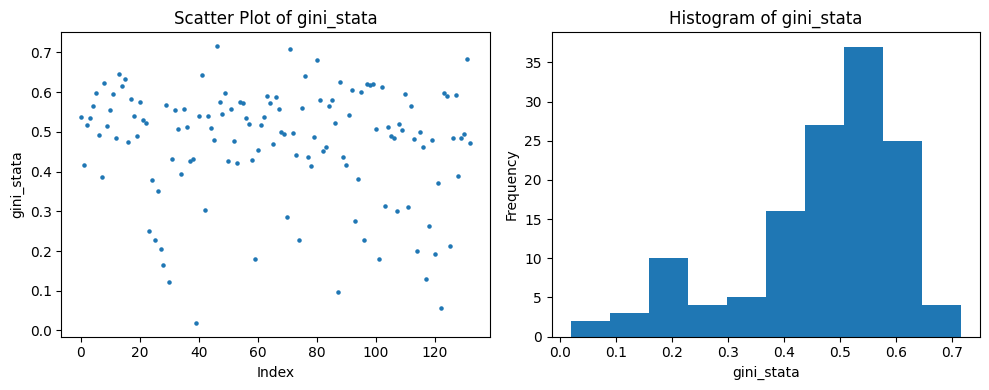

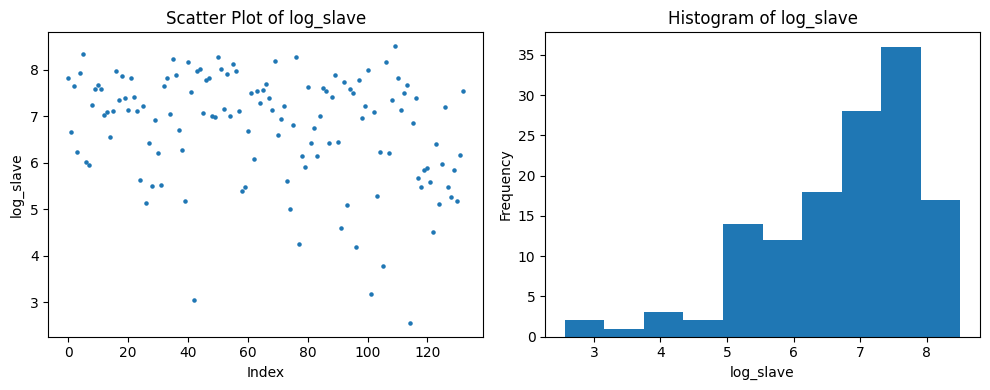

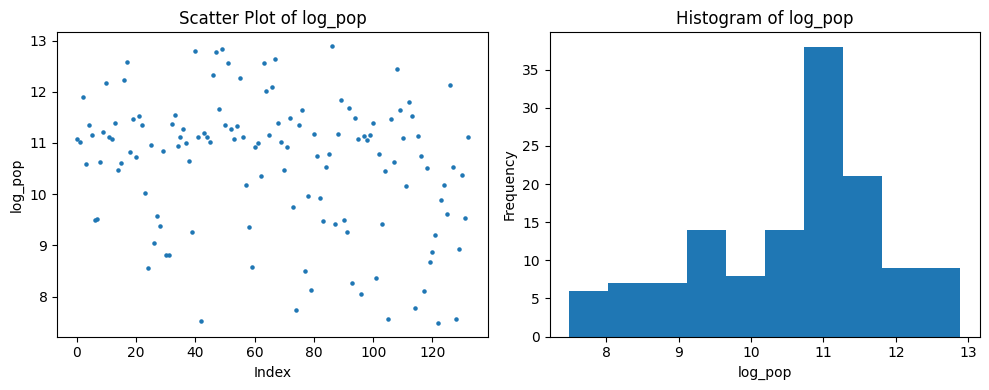

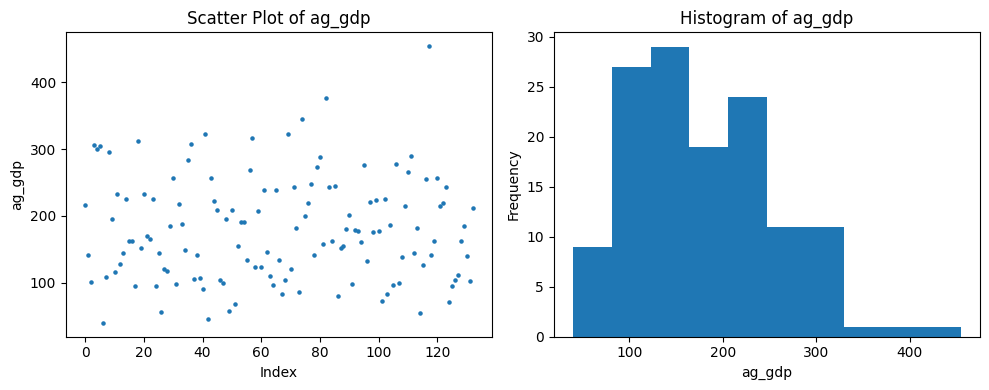

In [42]:
# Visualizing variables using scatter plots and histograms
for column in df_var_of_interest.columns:
    plt.figure(figsize=(10, 4))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(df_var_of_interest[column])), df_var_of_interest[column], s=5)
    plt.title("Scatter Plot of {}".format(column))
    plt.xlabel("Index")
    plt.ylabel(column)

    # Histogram
    plt.subplot(1, 2, 2)
    plt.hist(df_var_of_interest[column].dropna(), bins=10)
    plt.title("Histogram of {}".format(column))
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [43]:
df_var_of_interest.head()

,sum_crime,gini_stata,log_slave,log_pop,ag_gdp
35,36979,0.53805,7.826842,11.085215,216.719025
65,20997,0.41603,6.654152,11.014539,141.451736
47,20186,0.51740,7.638198,11.891136,101.144867
39,16208,0.53580,6.226537,10.596109,305.789734
43,14818,0.56524,7.929846,11.346765,300.366394


In [3]:
AK_pop = pd.read_csv("/Users/jakesharadin/Desktop/county_2010_2019_pop/county_AK.csv")
AL_pop = pd.read_csv("/Users/jakesharadin/Desktop/county_2010_2019_pop/county_AL.csv")
CA_pop = pd.read_csv("/Users/jakesharadin/Desktop/county_2010_2019_pop/county_CA.csv")
GA_pop = pd.read_csv("/Users/jakesharadin/Desktop/county_2010_2019_pop/county_GA.csv")
IL_pop = pd.read_csv("/Users/jakesharadin/Desktop/county_2010_2019_pop/county_IL.csv")
KY_pop = pd.read_csv("/Users/jakesharadin/Desktop/county_2010_2019_pop/county_KY.csv")

# Concatenate the datasets
merged_pop = pd.concat([AK_pop, AL_pop, CA_pop, GA_pop, IL_pop, KY_pop], ignore_index=True)

# Check the result
merged_pop.head()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
0,50,5,1,Arkansas,Arkansas County,1,19019,9220,9799,1148,...,340,447,182,265,424,128,296,40.7,39.4,42.3
1,50,5,1,Arkansas,Arkansas County,2,19007,9214,9793,1148,...,338,447,182,265,424,128,296,40.7,39.4,42.3
2,50,5,1,Arkansas,Arkansas County,3,19009,9207,9802,1172,...,341,450,184,266,424,128,296,40.7,39.5,42.3
3,50,5,1,Arkansas,Arkansas County,4,18871,9136,9735,1183,...,347,447,184,263,419,128,291,40.9,39.9,42.1
4,50,5,1,Arkansas,Arkansas County,5,18964,9179,9785,1233,...,348,439,179,260,419,128,291,40.7,39.5,41.6


In [4]:
# Check the result
merged_pop.tail()

,SUMLEV,STATE,COUNTY,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
6967,50,21,239,Kentucky,Woodford County,8,25860,12437,13423,1470,...,388,462,178,284,410,142,268,42.4,41.8,43.1
6968,50,21,239,Kentucky,Woodford County,9,26118,12582,13536,1503,...,425,495,207,288,424,142,282,42.6,41.8,43.4
6969,50,21,239,Kentucky,Woodford County,10,26385,12668,13717,1541,...,435,518,221,297,440,140,300,42.5,41.9,43.2
6970,50,21,239,Kentucky,Woodford County,11,26491,12723,13768,1524,...,462,562,237,325,455,147,308,43.0,42.2,43.7
6971,50,21,239,Kentucky,Woodford County,12,26734,12826,13908,1461,...,485,568,231,337,498,167,331,43.0,42.3,43.7


In [5]:
# Drop the columns and rename "COUNTY" to "county"
merged_pop = merged_pop.drop(columns=["SUMLEV", "STATE"]).rename(columns={"COUNTY": "county"})

In [13]:
merged_pop.head(10)

,county,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,UNDER5_MALE,UNDER5_FEM,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
0,1,Arkansas,Arkansas County,1,19019,9220,9799,1148,569,579,...,340,447,182,265,424,128,296,40.7,39.4,42.3
1,1,Arkansas,Arkansas County,2,19007,9214,9793,1148,569,579,...,338,447,182,265,424,128,296,40.7,39.4,42.3
2,1,Arkansas,Arkansas County,3,19009,9207,9802,1172,575,597,...,341,450,184,266,424,128,296,40.7,39.5,42.3
3,1,Arkansas,Arkansas County,4,18871,9136,9735,1183,590,593,...,347,447,184,263,419,128,291,40.9,39.9,42.1
4,1,Arkansas,Arkansas County,5,18964,9179,9785,1233,632,601,...,348,439,179,260,419,128,291,40.7,39.5,41.6
5,1,Arkansas,Arkansas County,6,18755,9072,9683,1241,614,627,...,352,425,164,261,413,131,282,40.8,39.7,41.7
6,1,Arkansas,Arkansas County,7,18479,8908,9571,1222,599,623,...,353,414,162,252,429,137,292,41.1,40.2,42.1
7,1,Arkansas,Arkansas County,8,18330,8853,9477,1206,595,611,...,352,412,162,250,428,145,283,41.4,40.5,42.2
8,1,Arkansas,Arkansas County,9,18154,8749,9405,1246,625,621,...,344,408,166,242,442,151,291,41.6,40.8,42.5
9,1,Arkansas,Arkansas County,10,17872,8660,9212,1167,584,583,...,328,418,164,254,439,140,299,41.8,40.7,42.8


In [18]:
# Drop every year that is not 2010
merged_pop_filtered = merged_pop[merged_pop['YEAR'] == 1]
merged_pop_filtered.tail(5)
#merged_pop_filtered.shape #581 counties across these 6 states

,county,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,UNDER5_MALE,UNDER5_FEM,...,AGE7579_FEM,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM
6912,231,Kentucky,Wayne County,1,20813,10295,10518,1260,630,630,...,336,398,173,225,307,107,200,41.1,40.2,42.2
6924,233,Kentucky,Webster County,1,13621,6765,6856,921,484,437,...,219,286,107,179,271,80,191,40.1,38.8,41.4
6936,235,Kentucky,Whitley County,1,35637,17328,18309,2164,1102,1062,...,520,655,269,386,529,178,351,38.1,37.0,39.1
6948,237,Kentucky,Wolfe County,1,7355,3608,3747,480,259,221,...,123,127,55,72,107,38,69,40.9,40.4,41.5
6960,239,Kentucky,Woodford County,1,24939,11969,12970,1435,733,702,...,328,415,161,254,348,119,229,41.0,40.5,41.6


In [20]:
# Dictionary to map state names to their abbreviations
state_abbr = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR", "California": "CA",
    "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE", "Florida": "FL", "Georgia": "GA",
    "Hawaii": "HI", "Idaho": "ID", "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD", "Massachusetts": "MA",
    "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS", "Missouri": "MO", "Montana": "MT",
    "Nebraska": "NE", "Nevada": "NV", "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM",
    "New York": "NY", "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC", "South Dakota": "SD",
    "Tennessee": "TN", "Texas": "TX", "Utah": "UT", "Vermont": "VT", "Virginia": "VA", "Washington": "WA",
    "West Virginia": "WV", "Wisconsin": "WI", "Wyoming": "WY"
}

# Step 1: Remove "County" from all values in CTYNAME
merged_pop_filtered['CTYNAME'] = merged_pop_filtered['CTYNAME'].str.replace(" County", "", regex=False)

# Step 2: Map state names to abbreviations and create a new column 'STNAME_ABBREVIATION'
merged_pop_filtered['STNAME_ABBREVIATION'] = merged_pop_filtered['STNAME'].map(state_abbr)

# Step 3: Create 'county_state' by combining 'CTYNAME' and 'STNAME_ABBREVIATION'
merged_pop_filtered['county_state'] = merged_pop_filtered['CTYNAME'] + ", " + merged_pop_filtered['STNAME_ABBREVIATION']

# Display the updated DataFrame
merged_pop_filtered.head()

/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_11212/2253481030.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_pop_filtered['CTYNAME'] = merged_pop_filtered['CTYNAME'].str.replace(" County", "", regex=False)
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_11212/2253481030.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_pop_filtered['STNAME_ABBREVIATION'] = merged_pop_filtered['STNAME'].map(state_abbr)
/var/folders/vl/4mchf1rx7l7dljxrjt1ct0_80000gn/T/ipykernel_

,county,STNAME,CTYNAME,YEAR,POPESTIMATE,POPEST_MALE,POPEST_FEM,UNDER5_TOT,UNDER5_MALE,UNDER5_FEM,...,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,STNAME_ABBREVIATION,county_state
0,1,Arkansas,Arkansas,1,19019,9220,9799,1148,569,579,...,182,265,424,128,296,40.7,39.4,42.3,AR,"Arkansas, AR"
12,3,Arkansas,Ashley,1,21853,10598,11255,1423,735,688,...,190,260,374,114,260,40.3,39.6,40.9,AR,"Ashley, AR"
24,5,Arkansas,Baxter,1,41513,20023,21490,2020,1050,970,...,716,817,1414,519,895,50.6,49.6,51.7,AR,"Baxter, AR"
36,7,Arkansas,Benton,1,221339,109124,112215,17850,9136,8714,...,1562,2070,3442,1249,2193,34.3,33.6,35.2,AR,"Benton, AR"
48,9,Arkansas,Boone,1,36903,18066,18837,2234,1099,1135,...,397,505,829,267,562,41.4,39.8,42.9,AR,"Boone, AR"


In [32]:
# Merge 2010 population data with 1860 census data
merged_df = df_v1.merge(merged_pop_filtered, on="county_state", how="inner")  # or "outer" if you want to keep all rows
merged_df.head() #135 counties

,county_x,schedule1_count,schedule2_count,total_pop,log_slave,ag_output,ag_gdp,gini_x,cash_value_farms,state,...,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,STNAME_ABBREVIATION
0,10.0,360232.0,3475.0,363707.0,8.153350,32662909.0,89.805557,0.54031,129368094.0,Alabama,...,731,295,436,551,159,392,37.0,35.9,37.9,AL
1,30.0,292363.0,1537.0,293900.0,7.337588,27996221.0,95.257645,0.58392,152052217.0,Alabama,...,3934,1735,2199,3233,1176,2057,41.1,40.1,42.2,AL
2,50.0,395136.0,1872.0,397008.0,7.534763,31948684.0,80.473656,0.52155,142857209.0,Alabama,...,543,195,348,443,129,314,39.0,37.2,41.6,AL
3,70.0,136102.0,2639.0,138741.0,7.878155,24998235.0,180.179153,0.43734,99711086.0,Alabama,...,355,138,217,279,73,206,37.8,36.5,39.5,AL
4,90.0,375103.0,1078.0,376181.0,6.982863,21747586.0,57.811497,0.59723,88331569.0,Alabama,...,1035,418,617,808,234,574,39.0,38.0,40.0,AL


In [29]:
merged_df = merged_df.rename(columns={'county_x': 'county'})

# Display the updated DataFrame to confirm the change
merged_df.head()

,county,schedule1_count,schedule2_count,total_pop,log_slave,ag_output,ag_gdp,gini_x,cash_value_farms,state,...,AGE8084_TOT,AGE8084_MALE,AGE8084_FEM,AGE85PLUS_TOT,AGE85PLUS_MALE,AGE85PLUS_FEM,MEDIAN_AGE_TOT,MEDIAN_AGE_MALE,MEDIAN_AGE_FEM,STNAME_ABBREVIATION
0,10.0,360232.0,3475.0,363707.0,8.153350,32662909.0,89.805557,0.54031,129368094.0,Alabama,...,731,295,436,551,159,392,37.0,35.9,37.9,AL
1,30.0,292363.0,1537.0,293900.0,7.337588,27996221.0,95.257645,0.58392,152052217.0,Alabama,...,3934,1735,2199,3233,1176,2057,41.1,40.1,42.2,AL
2,50.0,395136.0,1872.0,397008.0,7.534763,31948684.0,80.473656,0.52155,142857209.0,Alabama,...,543,195,348,443,129,314,39.0,37.2,41.6,AL
3,70.0,136102.0,2639.0,138741.0,7.878155,24998235.0,180.179153,0.43734,99711086.0,Alabama,...,355,138,217,279,73,206,37.8,36.5,39.5,AL
4,90.0,375103.0,1078.0,376181.0,6.982863,21747586.0,57.811497,0.59723,88331569.0,Alabama,...,1035,418,617,808,234,574,39.0,38.0,40.0,AL


In [30]:
merged_df_2010_pop = merged_df.copy()

In [31]:
# Save merged_df_clean to a pickle file
with open('merged_df_2010_pop.pkl', 'wb') as f:
    pickle.dump(merged_df_2010_pop, f)

In [33]:
# Use df_2010_controls2_final df
with open('df_2010_controls2_final.pkl', 'rb') as f:
    df_2010_controls2_final = pickle.load(f)

# Create a copy
df_2010_copy = df_2010_controls2_final.copy()
df_2010_copy.head()

,county,schedule1_count,schedule2_count,total_pop_1860,log_slave,ag_output,ag_gdp,gini_x,cash_value_farms,state,...,mtv_theft_rate,log_murder_rate,log_mtv_theft_rate,log_crime_rate,ALAND_SQMI,AWATER_SQMI,total_sqmi,pop_density_2010,total_males_15_29_1860,pop_density_1860
0,10.0,360232.0,3475.0,363707.0,8.153350,32662909.0,89.805557,0.54031,129368094.0,Alabama,...,18.324751,2.318692,2.961387,8.510573,594.455,9.914,604.369,90.294175,50227.0,601.796254
1,30.0,292363.0,1537.0,293900.0,7.337588,27996221.0,95.257645,0.58392,152052217.0,Alabama,...,16.459551,0.437385,2.859887,8.448097,1589.863,437.410,2027.273,89.906490,42867.0,144.973075
2,50.0,395136.0,1872.0,397008.0,7.534763,31948684.0,80.473656,0.52155,142857209.0,Alabama,...,0.000000,0.000000,0.000000,7.853968,885.008,19.507,904.515,30.355494,55791.0,438.918094
3,70.0,136102.0,2639.0,138741.0,7.878155,24998235.0,180.179153,0.43734,99711086.0,Alabama,...,34.911630,1.679701,3.581061,8.132966,622.470,3.696,626.166,36.595727,21539.0,221.572235
4,90.0,375103.0,1078.0,376181.0,6.982863,21747586.0,57.811497,0.59723,88331569.0,Alabama,...,13.956247,1.501644,2.705129,8.147122,644.891,5.738,650.629,88.102436,56997.0,578.180499


In [35]:
df_var_of_interest = df_2010_copy[['log_murder_rate', 'log_mtv_theft_rate', 'log_crime_rate']]

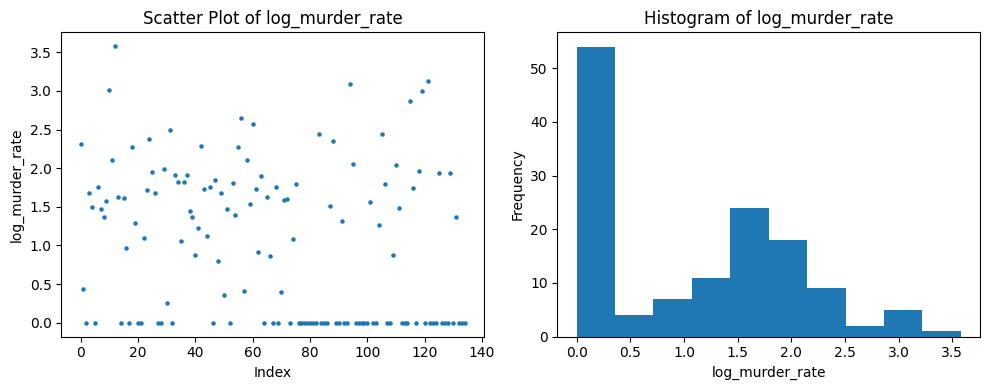

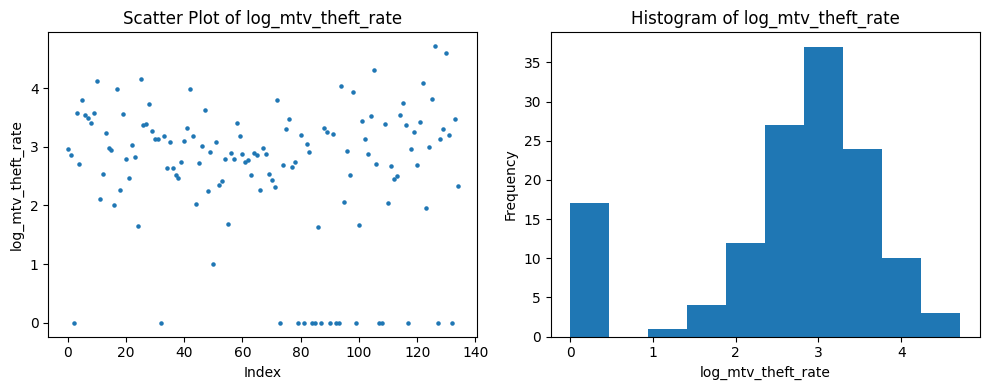

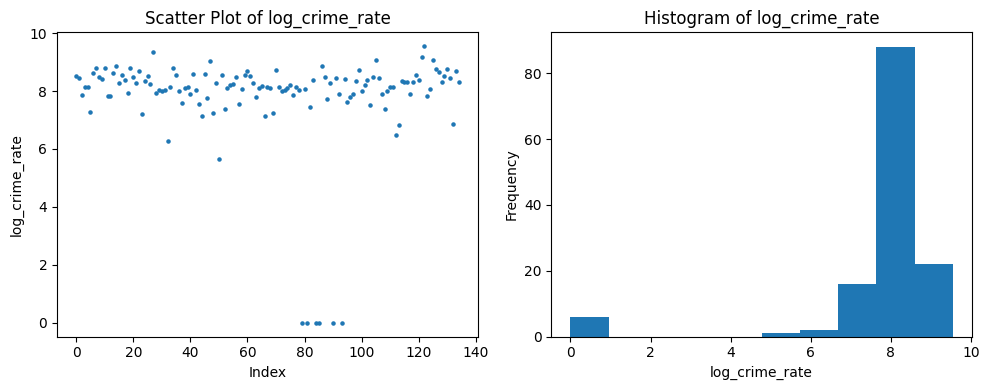

In [36]:
for column in df_var_of_interest.columns:
    plt.figure(figsize=(10, 4))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(df_var_of_interest[column])), df_var_of_interest[column], s=5)
    plt.title("Scatter Plot of {}".format(column))
    plt.xlabel("Index")
    plt.ylabel(column)

    # Histogram
    plt.subplot(1, 2, 2)
    plt.hist(df_var_of_interest[column].dropna(), bins=10)
    plt.title("Histogram of {}".format(column))
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [46]:
# Remove rows where all three rate are zero, data must not have been collected from these counties, dont fit trend
# Remove rows where log_crime_rate is zero
df_2010_removed_counties_0_crime_rate = df_2010_copy[df_2010_copy['log_crime_rate'] != 0]

# Display the first few rows to confirm
#df_2010_removed_counties_0_crime_rate.head()

# Check the number of remaining rows
df_2010_removed_counties_0_crime_rate.shape

(129, 130)

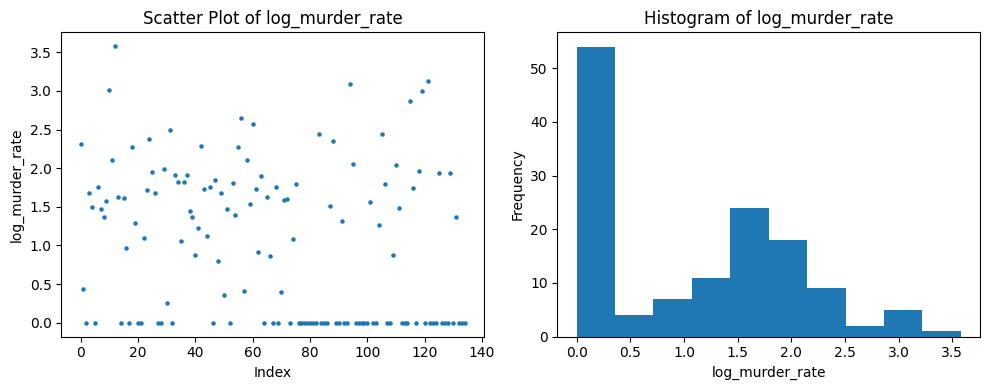

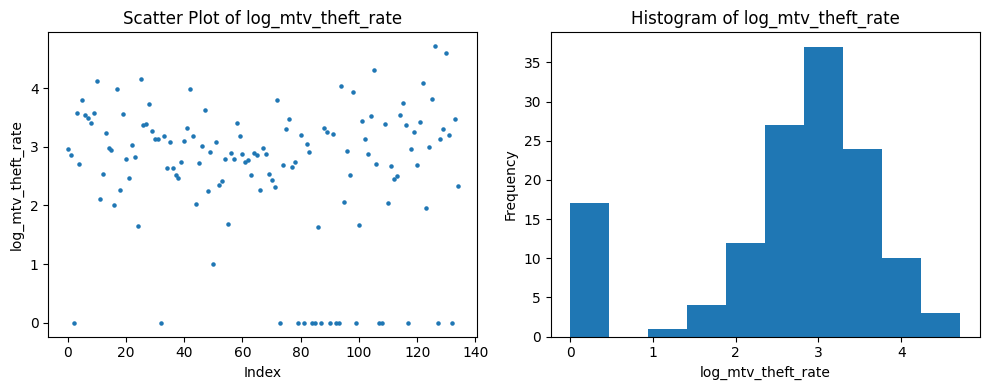

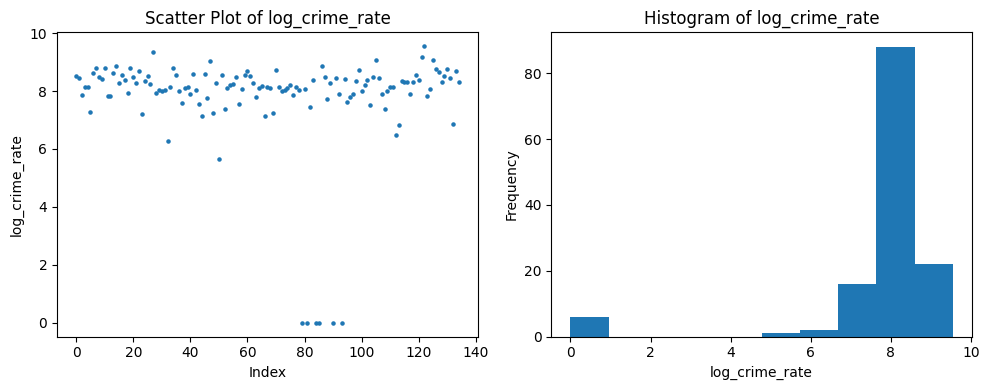

In [47]:
# Plot again
df_var_of_interest2 = df_2010_removed_counties_0_crime_rate

for column in df_var_of_interest.columns:
    plt.figure(figsize=(10, 4))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(df_var_of_interest[column])), df_var_of_interest[column], s=5)
    plt.title("Scatter Plot of {}".format(column))
    plt.xlabel("Index")
    plt.ylabel(column)

    # Histogram
    plt.subplot(1, 2, 2)
    plt.hist(df_var_of_interest[column].dropna(), bins=10)
    plt.title("Histogram of {}".format(column))
    plt.xlabel(column)
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

In [50]:
# 2010 population + crime data
with open('df_2010_controls2_final.pkl', 'rb') as f:
    df_2010_controls2_final = pickle.load(f)

# Create a copy
df_2010_copy = df_2010_controls2_final.copy()
df_2010_copy.head()

,county,schedule1_count,schedule2_count,total_pop_1860,log_slave,ag_output,ag_gdp,gini_x,cash_value_farms,state,...,log_murder_rate,log_mtv_theft_rate,log_crime_rate,ALAND_SQMI,AWATER_SQMI,total_sqmi,pop_density_2010,total_males_15_29_1860,pop_density_1860,total_males_15_29_2010
0,10.0,360232.0,3475.0,363707.0,8.153350,32662909.0,89.805557,0.54031,129368094.0,Alabama,...,2.318692,2.961387,8.510573,594.455,9.914,604.369,90.294175,50227.0,601.796254,5295
1,30.0,292363.0,1537.0,293900.0,7.337588,27996221.0,95.257645,0.58392,152052217.0,Alabama,...,0.437385,2.859887,8.448097,1589.863,437.410,2027.273,89.906490,42867.0,144.973075,15906
2,50.0,395136.0,1872.0,397008.0,7.534763,31948684.0,80.473656,0.52155,142857209.0,Alabama,...,0.000000,0.000000,7.853968,885.008,19.507,904.515,30.355494,55791.0,438.918094,3179
3,70.0,136102.0,2639.0,138741.0,7.878155,24998235.0,180.179153,0.43734,99711086.0,Alabama,...,1.679701,3.581061,8.132966,622.470,3.696,626.166,36.595727,21539.0,221.572235,2604
4,90.0,375103.0,1078.0,376181.0,6.982863,21747586.0,57.811497,0.59723,88331569.0,Alabama,...,1.501644,2.705129,8.147122,644.891,5.738,650.629,88.102436,56997.0,578.180499,5451


In [2]:
# List of columns to keep
columns_to_keep = [
    "log_murder_rate",
    "log_mtv_theft_rate",
    "log_crime_rate",
    "gini_stata",
    "log_slave",
    "pop_density_1860",
    "pop_density_2010",
    "total_males_15_29_1860",
    "total_males_15_29_2010",
    "county_state"
    "ag_gdp"
]

# Filter the DataFrame to keep only the specified columns
summary_stats = df_2010_copy[columns_to_keep]
#summary_stats.head()
summary_stats.describe()

NameError: name 'df_2010_copy' is not defined

In [73]:
df_2010_sorted = df_2010_copy.sort_values(by='schedule2_count').reset_index(drop=True)
df_2010_sorted

,county,schedule1_count,schedule2_count,total_pop_1860,log_slave,ag_output,ag_gdp,gini_x,cash_value_farms,state,...,log_murder_rate,log_mtv_theft_rate,log_crime_rate,ALAND_SQMI,AWATER_SQMI,total_sqmi,pop_density_2010,total_males_15_29_1860,pop_density_1860,total_males_15_29_2010
0,2810.0,2349.0,13.0,2362.0,2.564949,129040.0,54.631668,0.20002,372363.0,Georgia,...,0.000000,3.000738,8.079916,166.479,5.311,171.790,60.952326,325.0,13.749345,849
1,2990.0,1823.0,21.0,1844.0,3.044523,85240.0,46.225597,0.30360,474829.0,Georgia,...,0.000000,4.606577,8.744234,899.240,8.747,907.987,39.991762,259.0,2.030866,3971
2,2910.0,4297.0,24.0,4321.0,3.178054,311171.0,72.013657,0.18071,1104205.0,Georgia,...,0.000000,0.000000,8.666876,322.085,6.982,329.067,64.898638,578.0,13.131064,1466
3,2710.0,1876.0,44.0,1920.0,3.784190,184218.0,95.946877,0.48880,299145.0,Georgia,...,0.000000,1.954531,7.820804,437.307,6.701,444.008,37.161493,271.0,4.324246,1946
4,2410.0,3065.0,66.0,3131.0,4.189655,413906.0,132.196106,0.22700,1007046.0,Georgia,...,1.966275,2.966924,8.327466,370.134,6.893,377.027,43.169322,417.0,8.304445,1386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,470.0,63467.0,3745.0,67212.0,8.228177,19079449.0,283.869690,0.55789,78027489.0,Alabama,...,1.716340,2.831709,7.190585,978.738,15.106,993.844,44.091427,9390.0,67.628320,4061
131,870.0,81546.0,3883.0,85429.0,8.264363,17861832.0,209.083939,0.42743,59863813.0,Alabama,...,1.733701,3.190799,7.556033,608.665,4.543,613.208,34.983236,12505.0,139.314882,2686
132,290.0,109974.0,3921.0,113895.0,8.274102,24966660.0,219.207687,0.64109,122476483.0,Arkansas,...,0.000000,2.985842,8.863091,551.917,14.578,566.495,37.551964,15789.0,201.052083,1915
133,1010.0,65609.0,4134.0,69743.0,8.327001,21287959.0,305.234344,0.59900,96610685.0,Alabama,...,0.361855,1.009402,5.668589,785.355,14.557,799.912,286.735291,10640.0,87.188341,26133


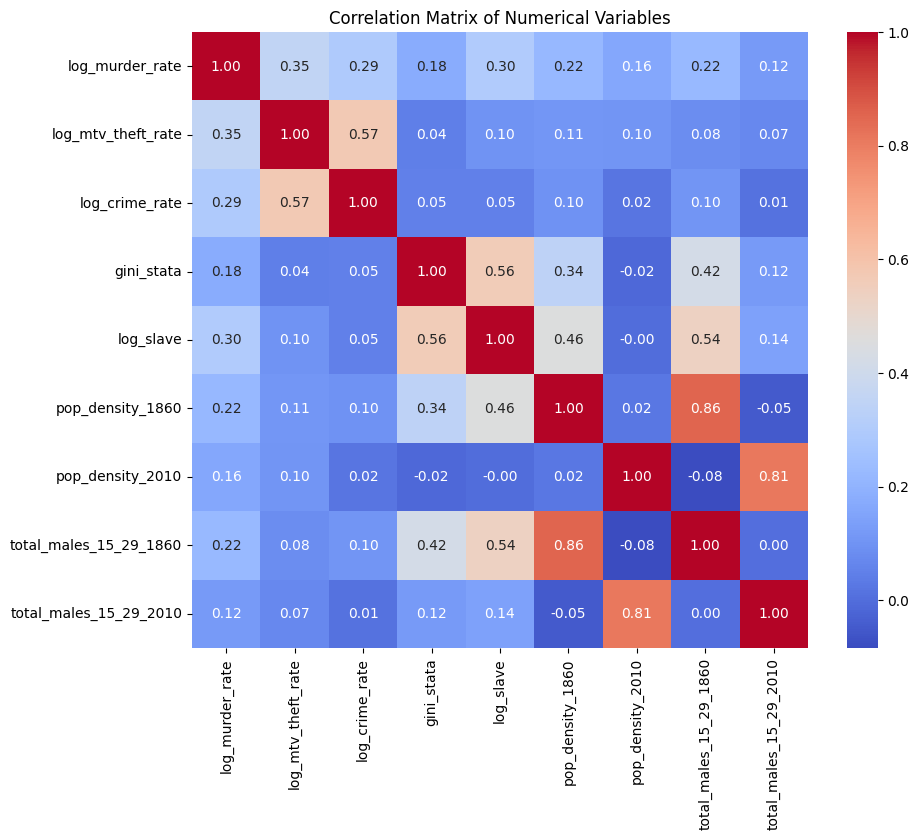

In [76]:
summary_stat_filter = summary_stats.drop(columns=['county_state'], errors='ignore')
correlation_matrix = summary_stat_filter.corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

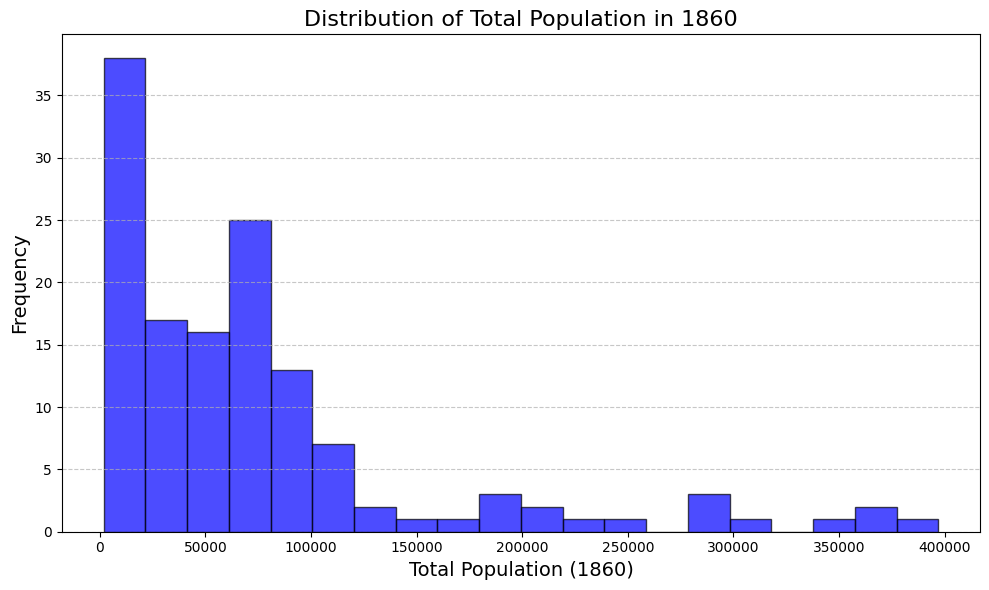

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['total_pop_1860'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Total Population in 1860', fontsize=16)
plt.xlabel('Total Population (1860)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()